# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Imports" data-toc-modified-id="Imports-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Imports</a></div><div class="lev1 toc-item"><a href="#Removing-baseline" data-toc-modified-id="Removing-baseline-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Removing baseline</a></div>

# Imports 

In [1]:
import os
os.chdir('../../')

import matplotlib.pyplot as plt

from spikelearn.models.shuffle_decoding import shuffle_val_predict
from spikelearn.data import io, select, to_feature_array
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression

In [5]:
r = io.load('DRRD 8', 'medium_smoothed')
df = to_feature_array(select(r, _min_duration=1.5), False)

In [6]:
df1, df2 = df.loc[:50], df.loc[50:100]

In [8]:
%load_ext autoreload
%autoreload 2

In [17]:
data_ = select( io.load('DRRD 8', 'medium_smoothed'),
                _min_duration=1.5, is_selected=True ).reset_index()

# Divide dataset into parts
## Define how the separation will happen
trials = data_.trial.unique()
slice_bounds = trials[::200]
n_slices = len(slice_bounds) - 1
## Enforce separation
dfs = [to_feature_array( select( data_,
                                _min_trial = slice_bounds[i],
                                _max_trial = slice_bounds[i+1]
                                ).set_index(['trial','unit']),
                        False, 'cropped') for i in range(n_slices)]

In [135]:
from xgboost import XGBClassifier

In [136]:
clf= XGBClassifier()#LogisticRegression(multi_class='multinomial', solver='saga', max_iter=1500, tol=1e-9)

In [13]:
clf.fit(dfs[0].values, dfs[0].reset_index().time)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [22]:
names=np.arange(len(dfs))

In [42]:
one_p, one_s = shuffle_val_predict( clf, [df.reset_index() for df in dfs], names,
                                 X=dfs[0].columns, y='time', group='trial',
                                 cv='sh', n_splits = 3, get_weights=False)

In [32]:
one_w

,time,unit,value,cv,trained_on
0,200,0,0.414980,0,0
1,300,0,0.407372,0,0
2,400,0,-0.056994,0,0
3,500,0,-0.267069,0,0
4,600,0,-0.136475,0,0
5,700,0,-0.057593,0,0
6,800,0,0.057407,0,0
7,900,0,-0.141089,0,0
8,1000,0,-0.105284,0,0
9,1100,0,-0.115255,0,0


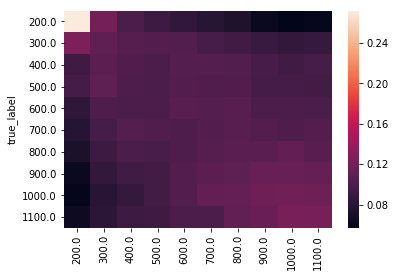

In [22]:
sns.heatmap(one_p.groupby('true_label').mean().iloc[:,:10])

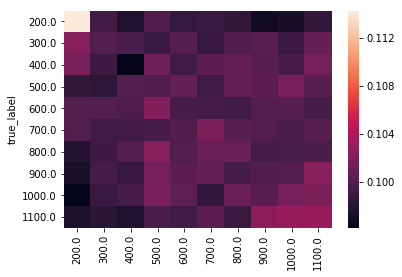

In [142]:
sns.heatmap(res_p.groupby('true_label').mean().iloc[:,:10])

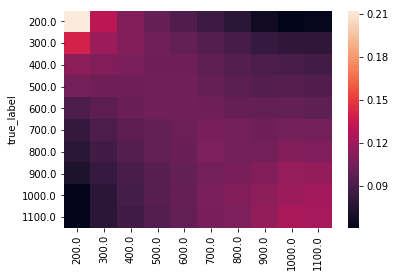

In [75]:
sns.heatmap(one_p.groupby('true_label').mean().iloc[:,:10])

In [51]:
clf.coef_.shape

(10, 27)

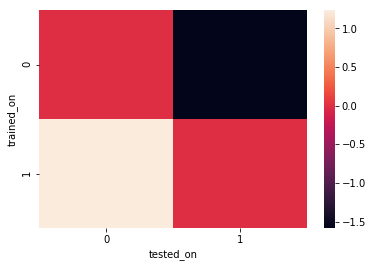

In [46]:
sns.heatmap(one_s.score_max.unstack(-1))

In [57]:
from sklearn.metrics import confusion_matrix

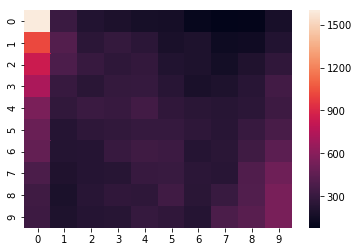

In [60]:
sns.heatmap(confusion_matrix(one_p.true_label, one_p.predictions_max))

---

# Removing baseline

In [3]:
from spikelearn.data import remove_baseline

In [4]:
%load_ext autoreload
%autoreload 2

In [14]:
from sklearn.linear_model import LogisticRegression

In [92]:
baseline = io.load('DRRD 7', 'epoched_spikes').baseline.unstack('unit')

In [119]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

In [122]:
df[df.columns] = ss.fit_transform(df)

In [153]:
clf = LogisticRegression()

In [154]:
res_p, res_s = shuffle_val_predict(clf, [df.reset_index(), dfnb.reset_index()], ['with_baseline','without_baseline'], 
                                          X=df.columns, y='time', group='trial', n_splits=15, get_weights = False)

/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3003: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/home/tevo/anaconda3/lib/python3.6/site-packages/scipy/stats/sta

In [162]:
res_p.groupby(['trained_on', 'tested_on']).mean().score_max

trained_on        tested_on       
with_baseline     with_baseline       0.312487
                  without_baseline    0.002200
without_baseline  with_baseline      -0.007218
                  without_baseline    0.027544
Name: score_max, dtype: float64

In [143]:
from spikelearn.measures.similarity import unit_similarity_evolution

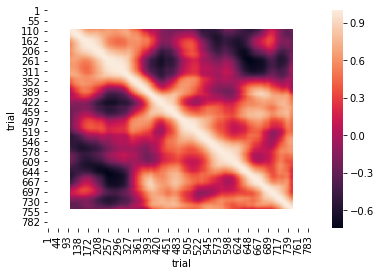

In [150]:
label= 'DRRD 8'
df = to_feature_array(select(io.load(label, 'medium_smoothed'), _min_duration=1.5, is_selected = True), False)
bline = io.load(label, 'baseline')
dfnb = remove_baseline(df, bline , .5)

sns.heatmap(unit_similarity_evolution(df[0], window=80))

In [2]:
sns.heatmap(unit_similarity_evolution(dfnb[0], window=80, subset='full'))

NameError: name 'sns' is not defined